In [1]:
%run DataLoader.ipynb
%run Visualization.ipynb

### 3D CNN with Residual Connection

In [2]:
# Build the model

import torch.nn as nn

# helper function to determine dimension after convolution
def conv_output_shape(in_dimension, kernel_size, stride):
    output_dim = []
    for (in_dim, kern_size, strd) in zip(in_dimension, kernel_size, stride):
        len = int(float(in_dim - kern_size) / strd + 1.)
        output_dim.append(len)
    
    return output_dim

        
class TemporalCNN(nn.Module):
    
    def _conv_unit(self, in_channels, out_channels, in_shape, kernel_size, stride, dropout_prob):
        r""" Return one 3D convolution unit
        
        Args:
            in_channels: Input channels of the Conv3D module
            out_channels: Output channels of the Conv3D module
            in_shape: Shape of the input image. i.e. The last 3 dimensions of the input tensor: D x H x W
            kernel_size: Kernel size
            stride: Stride
            dropout_prob: Probability of dropout layer
                         
        Output:
            (conv_module, aux_module, out_shape)
        """
        
        conv = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        dropout = nn.Dropout3d(p=dropout_prob)
        conv_module = nn.Sequential(conv, dropout).to(self.device_)
        out_shape = conv_output_shape(in_shape, kernel_size, stride)
        
        flatten = nn.Flatten(start_dim=2)
        aux = nn.Linear(in_features=np.prod(out_shape[-2:])*out_channels, out_features=128)
        aux_module = nn.Sequential(flatten, aux).to(self.device_)
        
        return conv_module, aux_module, out_shape
    
    def _linear_unit(self, in_features, out_features, dropout_prob):
        linear = nn.Linear(in_features, out_features)
        relu = nn.ReLU()
        dropout = nn.Dropout(p=dropout_prob)
        return nn.Sequential(linear, relu, dropout).to(self.device_), out_features
        
    
    def __init__(self, in_height, in_width, seq_len, dropout_prob=0.5, aux_history=10, device=None):
        r""" TemporalCNN: this model does 3D convolution on the H, W and temporal dimension
             It also includes residual connection from each Conv3D output to the final output
             
             Args:
                 in_height: image height
                 in_width: image width
                 seq_len: image sequence length
                 dropout_prob: prob for the dropout layer
                 aux_history: length of history to extract from seq_len
             
             Output:
                 nn.Module, accepts input with shape [batch_len, seq_len, C, in_height, in_width]
        """
        super(TemporalCNN, self).__init__()
        
        self.seq_len_ = seq_len
        self.in_width_ = in_width
        self.in_height_ = in_height
        self.aux_history_ = aux_history
        in_shape = (seq_len, in_height, in_width)
        
        self.device_ = device if device is not None else torch.device("cpu")
        
        # conv1
        self.conv0_, self.aux0_, out_shape = self._conv_unit(3, 64, in_shape, (3, 12, 12), (1, 6, 6), dropout_prob)
        # conv2
        self.conv1_, self.aux1_, out_shape = self._conv_unit(64, 64, out_shape, (2, 5, 5), (1, 2, 2), dropout_prob)
        # conv3
        self.conv2_, self.aux2_, out_shape = self._conv_unit(64, 64, out_shape, (2, 5, 5), (1, 1, 1), dropout_prob)
        # conv4
        self.conv3_, self.aux3_, out_shape = self._conv_unit(64, 64, out_shape, (2, 5, 5), (1, 1, 1), dropout_prob)
        
        # Flatten the last 3 dims
        self.flatten_ = nn.Flatten(start_dim=2).to(self.device_)
        
        # FC 1024
        self.linear0_, out_features = self._linear_unit(64*np.prod(out_shape[-2:]), 1024, dropout_prob)
        # FC 512
        self.linear1_, out_features = self._linear_unit(out_features, 512, dropout_prob)
        # FC 256
        self.linear2_, out_features = self._linear_unit(out_features, 256, dropout_prob)
        # FC 128
        self.linear3_ = nn.Linear(out_features, 128).to(device)
        
        self.elu_ = nn.ELU().to(self.device_)
        
    def forward(self, x):
        x = x.permute([0, 2, 1, 3, 4]) # swap channel and seq_len, 3D conv over seq_len as depth channel
                                       # now: [batch_size, channel, seq_len, H, W]
        
        x = self.conv0_(x) # every conv includes dropout
        x_permute = x.permute([0, 2, 1, 3, 4])[:,-self.aux_history_:,:,:,:]
        x_aux0 = self.aux0_(x_permute)
        x = self.conv1_(x)
        x_permute = x.permute([0, 2, 1, 3, 4])[:,-self.aux_history_:,:,:,:]
        x_aux1 = self.aux1_(x_permute)
        x = self.conv2_(x)
        x_permute = x.permute([0, 2, 1, 3, 4])[:,-self.aux_history_:,:,:,:]
        x_aux2 = self.aux2_(x_permute)
        x = self.conv3_(x)
        x = x.permute([0, 2, 1, 3, 4])
        x_permute = x[:,-self.aux_history_:,:,:,:]
        x_aux3 = self.aux3_(x_permute)

        x = self.flatten_(x)
        x = self.linear0_(x)
        x = self.linear1_(x)
        x = self.linear2_(x)
        x = self.linear3_(x)
        
        final_out = x + x_aux0 + x_aux1 + x_aux2 + x_aux3
        final_out = self.elu_(final_out)
        
        return final_out


### Autoregressive LSTM

In [3]:
# Autoregressive LSTM Module

class AutoregressiveLSTMCell(nn.Module):
    
    def __init__(self, target_size, visual_feature_size, hidden_size, device=None):
        r""" AutoregressiveModule takes visual feature from 3D CNN module, pass it
             first into an internal LSTM cell and then into a Linear network. The final
             output of this module is of dimension output_size.
             
             Args:
                 target_dim: dimsion of target value. for this application 3 (angle, speed, torque)
                 visual_feature_dim:
                 output_size: output size after the Linear network
                 autoregressive_mode: wether this module work as autoregressive mode or
                     just pass the ground truth to output
             Output:
                 nn.Module
        """
        super().__init__()
        
        self.target_size_ = target_size
        self.visual_feature_size_ = visual_feature_size
        self.hidden_size_ = hidden_size
        
        self.device_ = device if device is not None else torch.device("cpu")
        
        self.lstm_cell_ = nn.LSTMCell(input_size=target_size+visual_feature_size, hidden_size=hidden_size).to(self.device_)
        self.linear_ = nn.Linear(in_features=hidden_size+visual_feature_size+target_size, out_features=target_size).to(self.device_)
    
    def forward(self, visual_features, prev_target, prev_states):
        r"""
            Output:
                (output, target_ground_truth) for autoregressive_mode = True
                (output, (output, ))
        """
        lstm_input = torch.cat((visual_features, prev_target), dim=-1)
        h_t, c_t = self.lstm_cell_(lstm_input, prev_states)
        linear_input = torch.cat((visual_features, prev_target, h_t), dim=-1)
        output = self.linear_(linear_input)
        new_state = (h_t, c_t)
        
        return output, new_state
        
class AutoregressiveLSTM(AutoregressiveLSTMCell):
    
    def __init__(self, target_size, visual_feature_size, hidden_size, autoregressive_mode=True, device=None):
        super().__init__(target_size, visual_feature_size, hidden_size, device)
        self.autoregressive_mode_ = autoregressive_mode
    
    def forward(self, visual_features, init_target=None, init_states=None, target_groundtruth=None):
        # different from LSTM in torch library, we use the second dimension for sequence!
        assert self.autoregressive_mode_ or target_groundtruth is not None
        
        seq_len = visual_features.shape[1]
        batch_len = visual_features.shape[0]

        prev_target = torch.zeros(batch_len, self.target_size_, device=self.device_) if init_target is None else init_target
        prev_states = (torch.zeros(batch_len, self.hidden_size_, device=self.device_), 
                       torch.zeros(batch_len, self.hidden_size_, device=self.device_)) if init_states is None else init_states
        
        outputs = []
        states = []
        for seq_idx in range(seq_len):
            target, state = super().forward(visual_features[:, seq_idx, :], prev_target, prev_states)
            prev_target = target if self.autoregressive_mode_ else target_groundtruth[:, seq_idx, :]
            prev_states = state
            outputs.append(target)
            states.append(torch.stack(state))
            
        outputs = torch.stack(outputs)
        outputs = outputs.permute(1, 0, 2)  # dim: [batch, seq, target_size]
        states = torch.stack(states)
        states = states.permute(1, 2, 0, 3) # dim: [ [batch, seq, internal_size], [batch, seq, internal_size] ]
        
        return outputs, states
    
        

### Putting them together

In [4]:
class SteerNet(nn.Module):
    
    def __init__(self, device=None, dropout_prob=0.25):
        super(SteerNet, self).__init__()
        
        self.device_ = device if device is not None else torch.device("cpu")
        
        self.model_cnn_ = TemporalCNN(in_height=480, in_width=640, seq_len=15, dropout_prob=dropout_prob, aux_history=10, device=device)
        self.feature_dropout_ = nn.Dropout(p=dropout_prob)
        self.model_lstm_gt_ = AutoregressiveLSTM(target_size=3, visual_feature_size=128, hidden_size=32, autoregressive_mode=False, device=device)
        self.model_lstm_autoreg_ = AutoregressiveLSTM(target_size=3, visual_feature_size=128, hidden_size=32, autoregressive_mode=True, device=device)
        self.lstm_state_ = None
        
        self.train_ = True
    
    def forward(self, images, target=None):
        assert target is None or self.train_==True
        
        features = self.model_cnn_(images)
        features = self.feature_dropout_(features)
        
        if self.lstm_state_ is None:
            if self.train_:
                out_gt, state_gt = self.model_lstm_gt_(features, target_groundtruth=target)
            out_autoreg, state_autoreg = self.model_lstm_autoreg_(features)
        else:
            state_autoreg = self.lstm_state_
            state_gt = (state_autoreg[0].clone().detach(),
                        state_autoreg[1].clone().detach()) # copies the state. we don't opzimize the state of this LSTM with groundtruth input!
            if self.train_:
                out_gt, _ = self.model_lstm_gt_(features, init_states=state_gt, target_groundtruth=target)
            out_autoreg, state_autoreg = self.model_lstm_autoreg_(features, init_states=state_autoreg)
        if self.train_:
            self.lstm_state_ = (state_autoreg[0][:,-1,:].detach(), state_autoreg[1][:,-1,:].detach()) # take the state from last seq
        
        return (out_autoreg, out_gt) if self.train_ else out_autoreg
    
    def train(self, mode=True):
        self.train_ = mode

# Training

In [5]:
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler

# Load the data

# Use the whole training dataset to calculate target mean and stddev
udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                              root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                              transform=transforms.Compose([transforms.ToTensor()]),
                              select_camera='center_camera')
print("size of dataset: {}\nstat:\nmean: {}\nstd: {}".format(len(udacity_dataset), udacity_dataset.mean, udacity_dataset.std))

# Train / valid split with slices
dataset_size = int(len(udacity_dataset))
split_point = int(dataset_size * 0.8)
training_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                              root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                              transform=transforms.Compose([transforms.ToTensor()]),
                              select_camera='center_camera',
                              select_range=(0, split_point))
validation_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                transform=transforms.Compose([transforms.ToTensor()]),
                                select_camera='center_camera',
                                select_range=(split_point, dataset_size))
test_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_001_export_png/interpolated.csv',
                                root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_001_export_png/',
                                transform=transforms.Compose([transforms.ToTensor()]),
                                select_camera='center_camera')
batch_size = 15

cbs_train = ConsecutiveBatchSampler(data_source=training_set, batch_size=batch_size, shuffle=True, drop_last=True, seq_len=15, use_all_frames=True)
cbs_valid = ConsecutiveBatchSampler(data_source=validation_set, batch_size=batch_size, shuffle=True, drop_last=True, seq_len=15, use_all_frames=True)
cbs_test = ConsecutiveBatchSampler(data_source=test_set, batch_size=batch_size, shuffle=False, drop_last=True, seq_len=15, use_all_frames=True)

training_loader = DataLoader(training_set, sampler=cbs_train, collate_fn=(lambda x: x[0]))
validation_loader = DataLoader(validation_set, sampler=cbs_valid, collate_fn=(lambda x: x[0]))
test_loader = DataLoader(test_set, sampler=cbs_test, collate_fn=(lambda x: x[0]))

size of dataset: 33808
stat:
mean: {'angle': -0.008478613582381778, 'torque': -0.09063468015274655, 'speed': 15.625127605181328}
std: {'angle': 0.27152468334113167, 'torque': 0.7874424330514188, 'speed': 5.697122502690882}


In [6]:
import datetime
import subprocess
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

writer = SummaryWriter('runs/steernet-{}'.format(datetime.datetime.now()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} for training".format(device))

steernet = SteerNet(device=device, dropout_prob=0)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(steernet.parameters(), lr=1e-3)

def normalize_data(sample, channel, origin_dataset):
    result = (sample[channel] - origin_dataset.mean[channel]) / origin_dataset.std[channel]
    return result

def do_epoch(epoch_num=0):
    
    # training
    steernet.train()
    
    running_cost = 0.0
    total_iterations = 0
    for i, sample in enumerate(tqdm(training_loader, total=len(training_set)/batch_size)):
        
        angle = sample['angle'][:, -10:]
        torque = sample['torque'][:, -10:]
        speed = sample['speed'][:, -10:]
        images = sample['image'].to(device)
        angle_normalized = normalize_data(sample, 'angle', udacity_dataset)[:, -10:]
        torque_normalized = normalize_data(sample, 'torque', udacity_dataset)[:, -10:]
        speed_normalized = normalize_data(sample, 'speed', udacity_dataset)[:, -10:]
        
        target_normalized = torch.stack([angle_normalized, torque_normalized, speed_normalized])
        target_normalized = target_normalized.permute([1, 2, 0]).to(device) # (batch_size x seq_len x target_dim)
        angle = angle.to(device)
        
        optimizer.zero_grad()
        
        out_autoreg, out_gt = steernet(images, target_normalized)
        out_autoreg_angle = out_autoreg[:, :, 0] * udacity_dataset.std['angle'] + udacity_dataset.mean['angle']
        
        loss_angle = criterion(angle, out_autoreg_angle)
        loss_autoreg = criterion(out_autoreg, target_normalized)
        loss_gt = criterion(out_gt, target_normalized)
        
        loss_total = loss_angle + do_epoch.loss_target_weight * (loss_autoreg + loss_gt)
        running_cost += loss_angle.item()
        total_iterations = i+1
        loss_total.backward()
        
#         torch.nn.utils.clip_grad_norm_(steernet.model_lstm_gt_.parameters(), 15.0) # gradient clamping
#         torch.nn.utils.clip_grad_norm_(steernet.model_lstm_autoreg_.parameters(), 15.0) # gradient clamping
        
        writer.add_scalar('train - loss total epoch {}'.format(epoch_num), loss_total.item(), i)
        writer.add_scalar('train - loss angle epoch {}'.format(epoch_num), loss_angle.item(), i)
        writer.add_scalar('train - loss autoreg epoch {}'.format(epoch_num), loss_autoreg.item(), i)
        writer.add_scalar('train - loss gt epoch {}'.format(epoch_num), loss_gt.item(), i)
        
        optimizer.step()
    
    running_cost = running_cost / total_iterations
    writer.add_scalar('train - angle (RMSE)', np.sqrt(running_cost), epoch_num)
    print("Finished training epoch {}".format(epoch_num))
    
    git_label = subprocess.check_output(["git", "rev-parse", "--short=6", "HEAD"]).strip().decode('UTF-8') # get current git label
    torch.save(steernet.state_dict(), "saved_models/SteerNet/git-{}-epoch-{}".format(git_label, epoch_num))
    
    # validation
    
    with torch.no_grad(): # we don't require grad calcualation in the validation phase. it saves memory.
        steernet.eval()

        running_cost = 0.0
        total_iterations = 0
        for i, sample in enumerate(tqdm(validation_loader, total=len(validation_set)/batch_size)):
            angle = sample['angle'][:, -10:]
            torque = sample['torque'][:, -10:]
            speed = sample['speed'][:, -10:]
            images = sample['image'].to(device)
            angle_normalized = normalize_data(sample, 'angle', udacity_dataset)[:, -10:]
            torque_normalized = normalize_data(sample, 'torque', udacity_dataset)[:, -10:]
            speed_normalized = normalize_data(sample, 'speed', udacity_dataset)[:, -10:]
            
            target_normalized = torch.stack([angle_normalized, torque_normalized, speed_normalized])
            target_normalized = target_normalized.permute([1, 2, 0]).to(device) # (batch_size x seq_len x target_dim)
            angle = angle.to(device)

            out_autoreg = steernet(images)
            out_autoreg_angle = out_autoreg[:, :, 0] * udacity_dataset.std['angle'] + udacity_dataset.mean['angle']

            loss_angle = criterion(angle, out_autoreg_angle)
            loss_autoreg = criterion(out_autoreg, target_normalized)
            
            writer.add_scalar('valid - loss angle epoch {}'.format(epoch_num), loss_angle.item(), i)
            writer.add_scalar('valid - loss autoreg epoch {}'.format(epoch_num), loss_autoreg.item(), i)
            running_cost += loss_angle.item()
            total_iterations = i+1
        
        running_cost = running_cost / total_iterations
        writer.add_scalar('valid - angle (RMSE)', np.sqrt(running_cost), epoch_num)
                  
    print("Finished validating epoch {}".format(epoch_num))
    
    
do_epoch.loss_target_weight = 0.1

def do_test():
    
    with torch.no_grad(): # we don't require grad calcualation in the validation phase. it saves memory.
        steernet.eval()

        running_cost = 0.0
        total_iterations = 0
        for i, sample in enumerate(tqdm(test_loader, total=len(test_loader))):
            angle = sample['angle'][:, -10:]
            torque = sample['torque'][:, -10:]
            speed = sample['speed'][:, -10:]
            images = sample['image'].to(device)
            angle_normalized = normalize_data(sample, 'angle', udacity_dataset)[:, -10:]
            torque_normalized = normalize_data(sample, 'torque', udacity_dataset)[:, -10:]
            speed_normalized = normalize_data(sample, 'speed', udacity_dataset)[:, -10:]
            
            target_normalized = torch.stack([angle_normalized, torque_normalized, speed_normalized])
            target_normalized = target_normalized.permute([1, 2, 0]).to(device) # (batch_size x seq_len x target_dim)
            angle = angle.to(device)

            out_autoreg = steernet(images)
            out_autoreg_angle = out_autoreg[:, :, 0] * udacity_dataset.std['angle'] + udacity_dataset.mean['angle']

            loss_angle = criterion(angle, out_autoreg_angle)
            loss_autoreg = criterion(out_autoreg, target_normalized)
            
            writer.add_scalar('test - loss angle', loss_angle.item(), i)
            writer.add_scalar('test - loss autoreg', loss_autoreg.item(), i)
            running_cost += loss_angle.item()
            total_iterations = i+1
        
        running_cost = running_cost / total_iterations
        writer.add_scalar('test - angle (RMSE)', np.sqrt(running_cost))
        print('test RMSE: {}'.format(np.sqrt(running_cost)))

Using cuda for training


In [ ]:
for epoch in range(0,10):
    do_epoch(epoch)
    visualize_cnn(steernet.model_cnn_.conv0_[0])

In [19]:
steernet.load_state_dict(torch.load('saved_models/SteerNet/git-823727-epoch-2'))

<All keys matched successfully>

In [8]:
do_test()

NameError: name 'epoch_num' is not defined

(64, 3, 3, 12, 12)


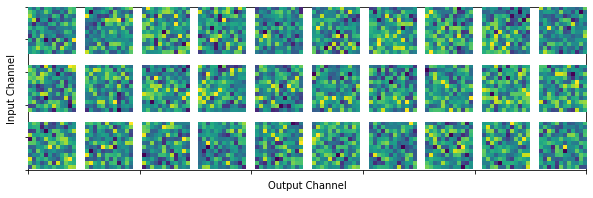

In [23]:
visualize_cnn(steernet.model_cnn_.conv0_[0])